# 02. Machine Learning for music playlists: Data Visualisation

This is the second post in a series of posts devoted to analysis of iTunes music library using Scikit-Learn tools.   
This notebook covers visualisation and overview of data I prepared in the [01_Data_preparation](http://localhost:8888/notebooks/01_Data_preparation.ipynb). 

In the previous step I parsed iTunes music library xml file to create a sqlite3 database of tracks for the test dataset. I also transformed the csv file with labeled tracks into a sqlite3 database for the training set. Using the Echo Nest API I got track attributes for both sets.

As a result of the above manipulations I have two databases (DBs): 
* training DB contains 91 labeled tracks with one of the three classes: "cycling", "yoga", "ballet";
* test DB contains 331 non-labeled tracks. 

The next step in my analysis is to visualize both datasets and examine track attributes. 

For the summary of this analysis, its goals, methods and installation notes please go to [00_Summary](http://localhost:8888/notebooks/00_Summary.ipynb). 
Data gathering and cleaning process are described in detail in the [01_Data_preparation](http://localhost:8888/notebooks/01_Data_preparation.ipynb). As a shortcut, in this notebook I import module "data_processing.py" where I perform steps from the previous notebook. 

I use **[Matplotlib](http://matplotlib.org/)** and **[Seaborn](https://stanford.edu/~mwaskom/software/seaborn/)** packages for data visualization. 

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd
from sqlitedict import SqliteDict

# import my module from the previous notebook
import data_processing as prs

# set seaborn plot defaults
import seaborn as sns; 
sns.set(palette="husl")
sns.set_style("ticks")

# format floating point numbers
# within pandas data structures
pd.set_option('float_format', '{:.2f}'.format)

In [4]:
# train DB
train_db = SqliteDict('./labeled_tracks', autocommit=True)

# test DB
test_db = SqliteDict('./itunes_tracks',
                     autocommit=True)

## Data overview  
  
I have two DBs with track attributes data from the Echo Nest API. Next step is to read in data from both DBs and take a look at what I'm working with.

I transform DBs into pandas dataframes (DF), which one can think of as an Excel-like table of values. Dataframes have various methods that can be called to easily learn about the data contained in them. I leave in the DF only tracks with  attributes data for further analysis. 

### Training data overview

In [5]:
# create a df with training data
train_df = prs.read_db_in_pandas(train_db)

In [6]:
# list of categories
categories = list(pd.unique(train_df.category.ravel()))

print ("Tracks in the dataset belong " 
       "to {} categories: {}."
       .format(len(categories), ", ".join(categories)))

# count tracks in each category
cat_count = pd.value_counts(train_df.category.ravel())

# print categories
for category in categories:
    print ("{} tracks represent \'{}\' category."
           .format(cat_count[category], category))

Tracks in the dataset belong to 3 categories: cycling, yoga, ballet.
31 tracks represent 'cycling' category.
23 tracks represent 'yoga' category.
34 tracks represent 'ballet' category.


In [ ]:
#TODO: show that "key", "mode", and "time_signature" are categorical

### Training data visualisation
I plot attributes with pairplot (sns.pairplot) function to examine pairwise relationships in a dataset. Pairplots are a simple representation using a set of 2D scatterplots, plotting each component against another component.

The diagonal Axes show the univariate distribution of the data for the variable in that column. Each track class is coloured according to their classification with a different colour so I can see the behaviour of classes. 

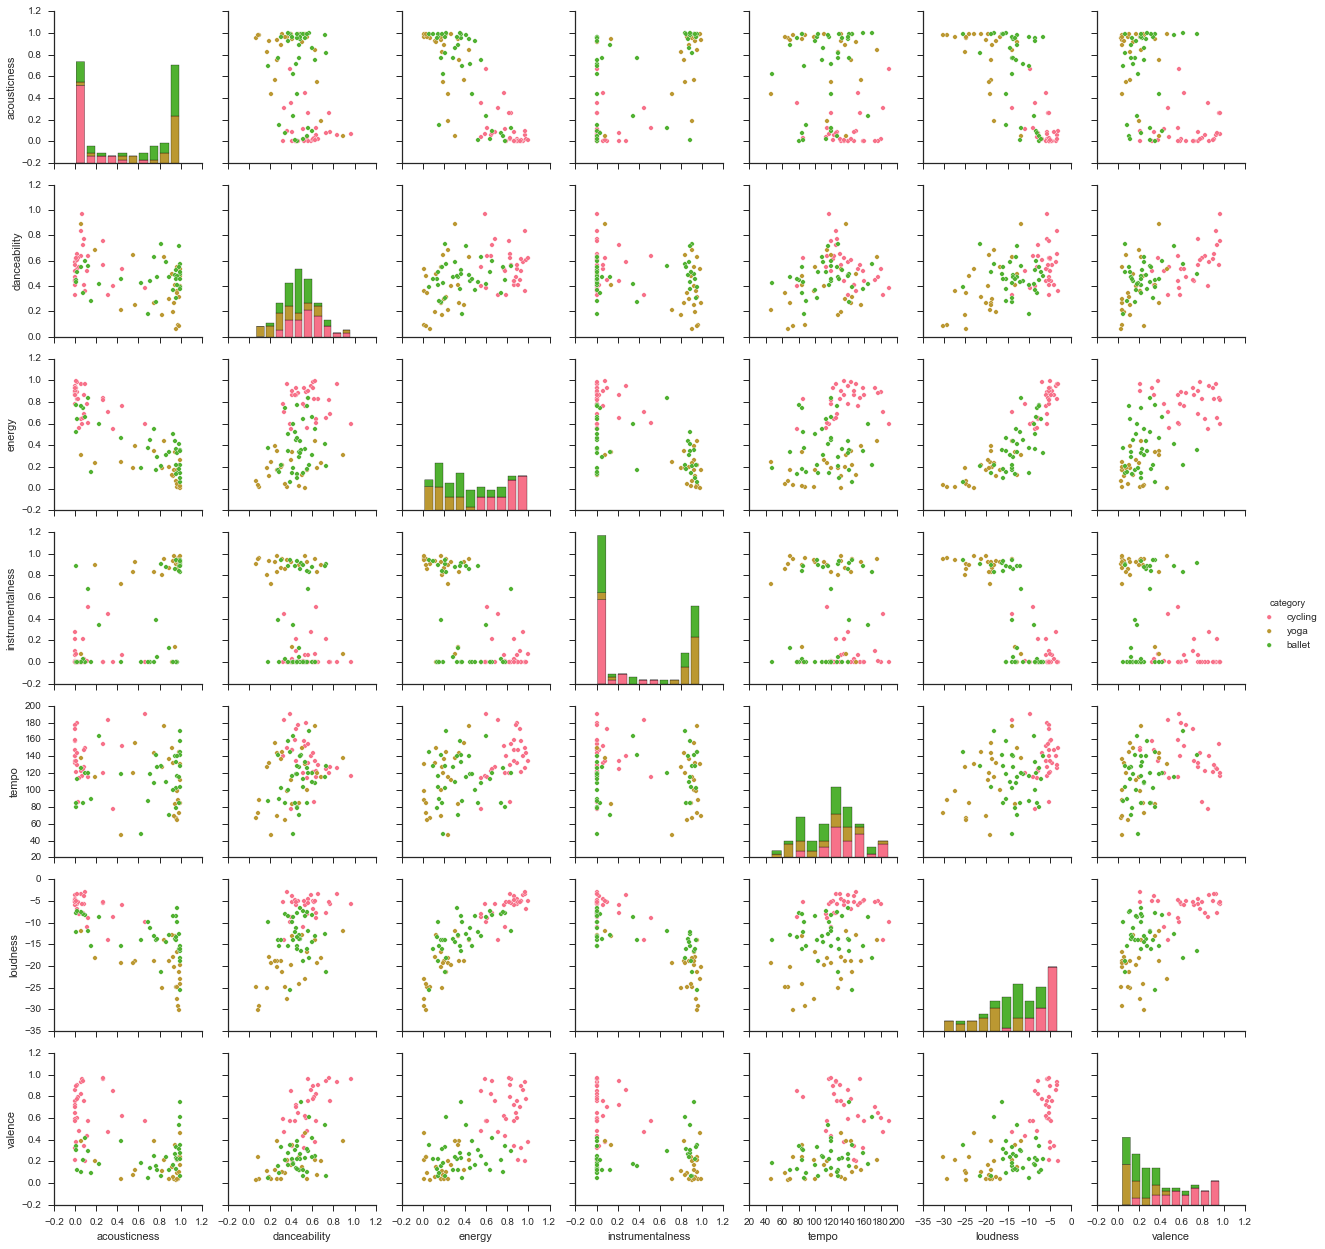

In [7]:
sns.pairplot(train_df, hue="category", 
             vars=['acousticness', 'danceability', 
                   'energy', 'instrumentalness', 
                   'tempo', 'loudness','valence'])

Datapoints from "cycling" and "yoga" classes tend to cluster together, whereas the "ballet" class is very spread out. 

The rest of attributes, "key", "mode", and "time_signature" are discrete, not continuous as other features, with a limited number of values, or categorical bins. E.g. "time_signature" has 4 values: 1, 3, 4 or 5. Each track falls into one of these categorical bins. To visualize these bins I create a count plot. Count plot shows the counts of observations in each categorical bin using bars.   

In [12]:
sns.countplot?

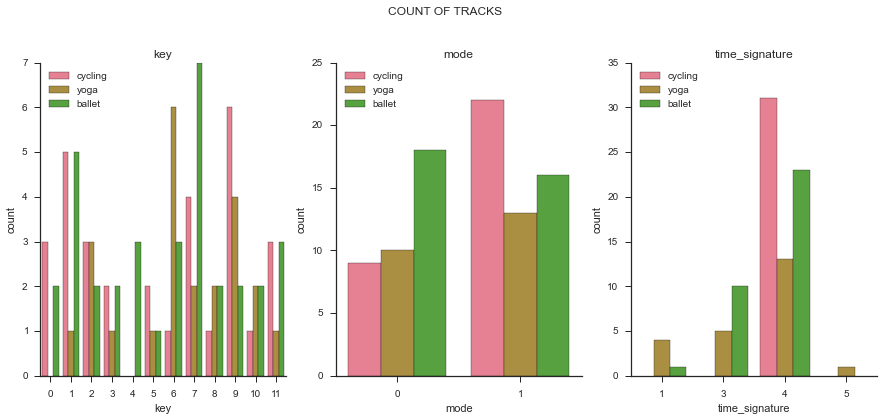

In [28]:
# create 3 subplots
fig0, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3,
                                      sharey=False,
                                      figsize=(15,6))

# space between the title and the plot
plt.subplots_adjust(top=0.85) 
# add a title
fig0.suptitle('COUNT OF TRACKS')

# remove the top and right spines from plots
sns.despine()

def count_plot_attr(df, hue):
    """Create count plot for 3 attributes.
    """
    attr = [('key', ax0), 
            ('mode', ax1),
            ('time_signature', ax2)]
    
    for item, ax in attr:
        # add title for a subplot
        ax.set_title(item)
        
        # create a count plot
        sns.countplot(x=item, hue=hue, 
                      data=df,
                      ax=ax)
        # add legend
        ax.legend(loc='upper left')
        
count_plot_attr(df=train_df, hue="category")

TODO: summary

I group the data by categories and then calculate mean value and standard deviation for every attribute. 

In [36]:
# group by category
grouped = train_df.groupby(['category'])

# mean value in every attribute
print "Mean values"
train_mean = grouped.mean()
train_mean

Mean values


,acousticness,danceability,energy,instrumentalness,key,loudness,mode,speechiness,tempo,time_signature,valence
category,,,,,,,,,,,
ballet,0.67,0.47,0.38,0.39,5.47,-12.95,0.47,0.05,114.74,3.62,0.25
cycling,0.10,0.56,0.81,0.06,5.35,-6.11,0.71,0.06,138.75,4.00,0.67
yoga,0.81,0.38,0.18,0.79,6.43,-20.41,0.57,0.05,111.25,3.30,0.17


The mean (or average) is just the sum of the data divided by its count. This value reveals the differences between the three groups and prooves the assumptions I made just by observing the above plot.
The mean is strongly affected by outliers and is not a robust estimator for central location: the mean is not necessarily a typical example of the data points. For more robust, although less efficient, measure of central location, I use median(). 
TODO: write a summary.

In [37]:
# median value in every attribute
print "Median values"
train_median = grouped.median()
train_median

Median values


,acousticness,danceability,energy,instrumentalness,key,loudness,mode,speechiness,tempo,time_signature,valence
category,,,,,,,,,,,
ballet,0.84,0.46,0.35,0.09,6,-13.15,0,0.05,118.04,4,0.22
cycling,0.03,0.55,0.84,0.00,6,-5.31,1,0.06,134.95,4,0.71
yoga,0.93,0.35,0.19,0.91,6,-19.37,1,0.04,114.97,4,0.12


In [9]:
adfh = (train_median / train_mean) - 1
adfh

,acousticness,danceability,energy,instrumentalness,key,loudness,mode,speechiness,tempo,time_signature,valence
category,,,,,,,,,,,
ballet,0.24,-0.02,-0.08,-0.86,0.07,0.00,-1.00,-0.11,0.02,0.11,-0.12
cycling,-0.65,-0.02,0.05,-0.99,0.05,-0.16,0.39,-0.05,-0.01,0.00,0.03
yoga,0.16,-0.08,0.04,0.14,-0.07,-0.05,0.77,-0.08,0.03,0.21,-0.29


In [44]:
train_df[(train_df['category'] == 'yoga') & (train_df['acousticness'] <= 0.5)]

,song_title,acousticness,artist,category,danceability,energy,instrumentalness,key,loudness,mode,speechiness,tempo,time_signature,valence
21,Flowers for Yulia,0.43,Max Richter,yoga,0.21,0.24,0.72,9,-19.26,0,0.04,46.22,3,0.04
37,Moments in love,0.05,Art of Noise,yoga,0.89,0.31,0.08,9,-11.86,1,0.04,137.91,4,0.39
86,petrichor,0.19,set and setting,yoga,0.68,0.24,0.90,6,-18.10,0,0.05,114.97,3,0.20


In [39]:
grouped.describe()

acousticness  danceability  energy  instrumentalness   key  \
category                                                                     
ballet   count         34.00         34.00   34.00             34.00 34.00   
         mean           0.67          0.47    0.38              0.39  5.47   
         std            0.38          0.12    0.22              0.43  3.44   
         min            0.00          0.18    0.06              0.00  0.00   
         25%            0.28          0.41    0.19              0.00  2.25   
         50%            0.84          0.46    0.35              0.09  6.00   
         75%            0.96          0.54    0.52              0.88  7.75   
         max            1.00          0.73    0.84              0.95 11.00   
cycling  count         31.00         31.00   31.00             31.00 31.00   
         mean           0.10          0.56    0.81              0.06  5.35   
         std            0.16          0.15    0.14              0.13  3.83   
         min            0.00          0.33    0.55              0.00  0.00   
         25%            0.00          0.44    0.70              0.00  1.50   
         50%            0.03          0.55    0.84              0.00  6.00   
         75%            0.10          0.63    0.91              0.06  9.00   
         max            0.66          0.97    0.99              0.51 11.00   
yoga     count         23.00         23.00   23.00             23.00 23.00   
         mean           0.81          0.38    0.18              0.79  6.43   
         std            0.27          0.21    0.13              0.29  2.87   
         min            0.05          0.06    0.01              0.00  1.00   
         25%            0.78          0.23    0.06              0.83  5.50   
         50%            0.93          0.35    0.19              0.91  6.00   
         75%            0.97          0.52    0.25              0.95  9.00   
         max            0.99          0.89    0.44              0.98 11.00   

                loudness  mode  speechiness  tempo  time_signature  valence  
category                                                                     
ballet   count     34.00 34.00        34.00  34.00           34.00    34.00  
         mean     -12.95  0.47         0.05 114.74            3.62     0.25  
         std        4.29  0.51         0.02  28.02            0.65     0.16  
         min      -25.59  0.00         0.03  47.64            1.00     0.05  
         25%      -15.36  0.00         0.03  91.91            3.00     0.13  
         50%      -13.15  0.00         0.05 118.04            4.00     0.22  
         75%       -8.95  1.00         0.06 132.27            4.00     0.31  
         max       -6.63  1.00         0.14 169.99            4.00     0.75  
cycling  count     31.00 31.00        31.00  31.00           31.00    31.00  
         mean      -6.11  0.71         0.06 138.75            4.00     0.67  
         std        2.39  0.46         0.03  26.16            0.00     0.23  
         min      -13.93  0.00         0.03  77.73            4.00     0.20  
         25%       -7.29  0.00         0.04 122.48            4.00     0.53  
         50%       -5.31  1.00         0.06 134.95            4.00     0.71  
         75%       -5.00  1.00         0.07 153.42            4.00     0.86  
         max       -2.99  1.00         0.17 190.04            4.00     0.97  
yoga     count     23.00 23.00        23.00  23.00           23.00    23.00  
         mean     -20.41  0.57         0.05 111.25            3.30     0.17  
         std        5.09  0.51         0.02  34.58            1.18     0.13  
         min      -30.24  0.00         0.03  46.22            1.00     0.03  
         25%      -24.44  0.00         0.03  84.25            3.00     0.05  
         50%      -19.37  1.00         0.04 114.97            4.00     0.12  
         75%      -17.95  1.00         0.05 137.40            4.00     0.23  
         max      -11.86  1.00       

In [16]:
print "Standard deviation"
grouped.std()

Standard deviation


,acousticness,danceability,energy,instrumentalness,key,loudness,mode,speechiness,tempo,time_signature,valence
category,,,,,,,,,,,
cycling,0.22,0.14,0.14,0.19,4.06,2.51,0.43,0.03,22.40,0.00,0.21
focus,0.37,0.23,0.23,0.16,3.71,6.69,0.50,0.03,38.17,0.85,0.20
yoga,0.22,0.19,0.14,0.25,2.97,5.85,0.48,0.01,27.25,1.05,0.21


Standard devation is a measure of how spread out numbers are. The "cycling" class has the least spread out numbers, where the "focus" class is rather inconsistent.  

I make a violinplot to visualize the data. Violin plot combines a boxplot with the kernel density estimation procedure to provide a better description of the distribution of values. Additionally, the quartile values from the boxplot are shown inside the violin by adding inner="quartile" parameter. Mean values are marked with a white cross. 

I also use the function swarmplot() that positions each scatterplot point on the categorical axis with an algorithm that avoids overlapping points. This gives a better representation of the distribution of values.

Here I plot features "acousticness", "danceability", "energy", "instrumentalness", and "valence". These features  spread out from 0 to 1. Note that due to the shape of the plot the figure might go below 0 and above 1. Seaborn allows to limit the violin range within the range of the observed data (cut=0), but here I leave them as is.  

"Speechiness" is on the same level in three classes, it's not interesting to plot it. 

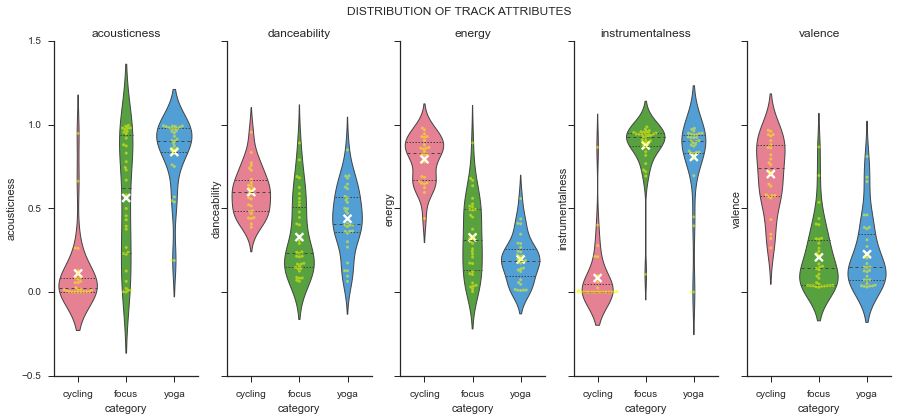

In [10]:
# create 5 subplots
fig1, (ax3, ax4, 
      ax5, ax6, 
      ax7) = plt.subplots(nrows=1, ncols=5,
                          sharey=True, # leave y ticks only on the first column of plots
                          figsize=(15,6))

# add a title
fig1.suptitle('DISTRIBUTION OF TRACK ATTRIBUTES')

# remove the top and right spines from plots
sns.despine()

def violin_plot_attr():
    """Create violin plot and swarmplot for
    5 attributes.
    """
    attr = [('acousticness', ax3), 
            ('danceability', ax4),
            ('energy', ax5), 
            ('instrumentalness', ax6), 
            ('valence', ax7)]
    
    for item, ax in attr:
        # add title for a subplot
        ax.set_title(item)
        
        # create a violin plot
        sns.violinplot(x="category", y=item, 
                       data=train_df, 
                       inner="quartile", # draw the quartiles of the distribution
                       linewidth=1,
                       ax=ax)
        
        # add marker for mean values
        sns.pointplot(x="category", y=item,
                      data=train_df, 
                      markers="x", 
                      ci=None, # remove confidence intervals 
                      join=False, 
                      color="white", 
                      alpha=.5, # alpha adds saturation
                      ax=ax)
        
        # create a swarmplot on top of the violin plot
        sns.swarmplot(x="category", y=item, 
                      data=train_df, 
                      alpha=.5, 
                      size=3, 
                      color="yellow", 
                      edgecolor="gray", 
                      ax=ax)
        

violin_plot_attr()

TODO: summary

To plot "loudness" and "tempo" I use box plot, which is the foundation of the violin plot. A box plot (or box-and-whisker plot) shows the distribution of quantitative data in a way that facilitates comparisons between variables or across levels of a categorical variable. The box shows the quartiles of the dataset while the whiskers extend to show the rest of the distribution, except for points that are determined to be “outliers” using a method that is a function of the inter-quartile range.

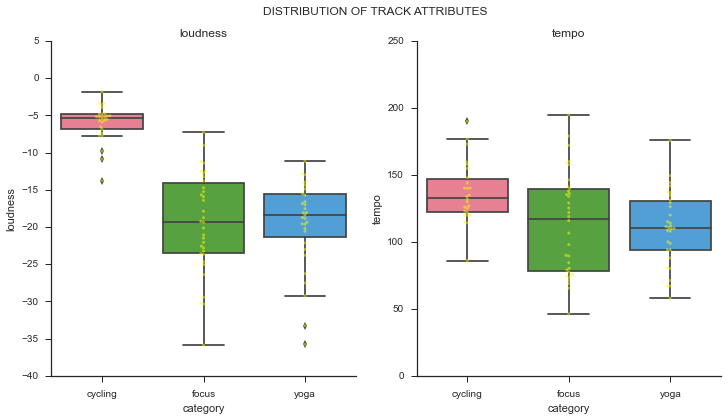

In [11]:
# create 2 subplots
fig2, (ax8, ax9) = plt.subplots(nrows=1, ncols=2,
                              sharey=False,
                              figsize=(12,6))

fig2.suptitle('DISTRIBUTION OF TRACK ATTRIBUTES')

# remove the top and right spines from plots
sns.despine()

def box_plot_attr():
    """Create box plot and swarmplot for
    2 attributes.
    """
    attr = [('loudness', ax8), 
            ('tempo', ax9)]
    
    for item, ax in attr:
        # add title for a subplot
        ax.set_title(item)

        # create a box plot
        sns.boxplot(x="category", y=item,
                   data=train_df,
                    ax=ax)
        
        # create a swarmplot on top of the violin plot
        sns.swarmplot(x="category", y=item, 
                      data=train_df, 
                      alpha=.5, size=3,
                      color="yellow", edgecolor="gray", 
                      ax=ax)
        
        
box_plot_attr()

In [ ]:
# TODO: write a summary

### Test data overview

Now I move on to exploration of the test dataset.

In [10]:
# create a df with test data
test_df = prs.read_db_in_pandas(test_db)

print ("There are {} tracks in the test dataframe."
       .format(len(test_df)))
print "\nSummary statistics: "
test_df.describe()

There are 331 tracks in the test dataframe.

Summary statistics: 


,acousticness,danceability,energy,instrumentalness,key,loudness,mode,speechiness,tempo,time_signature,valence
count,331.00,331.00,331.00,331.00,331.00,331.00,331.00,330.00,331.00,331.00,331.00
mean,0.27,0.61,0.64,0.26,5.13,-9.00,0.56,0.07,118.47,3.96,0.52
std,0.29,0.16,0.21,0.34,3.66,4.20,0.50,0.07,24.94,0.29,0.25
min,0.00,0.14,0.02,0.00,0.00,-29.23,0.00,0.02,52.61,1.00,0.03
25%,0.02,0.52,0.49,0.00,2.00,-10.71,0.00,0.03,101.02,4.00,0.32
50%,0.15,0.63,0.68,0.04,5.00,-8.20,1.00,0.04,119.90,4.00,0.53
75%,0.46,0.71,0.80,0.58,8.00,-6.19,1.00,0.06,131.62,4.00,0.72
max,0.99,0.95,1.00,0.95,11.00,-1.65,1.00,0.69,201.51,5.00,0.97


These data give us some idea about tracks in the test set. On average, music in my library has high level of energy, danceability, and loudness. It's not very acoustic and instrumental.  

I use countplot for "key", "mode", and "time_signature" attributes, which are discrete, to show the counts of tracks in each bin using bars.

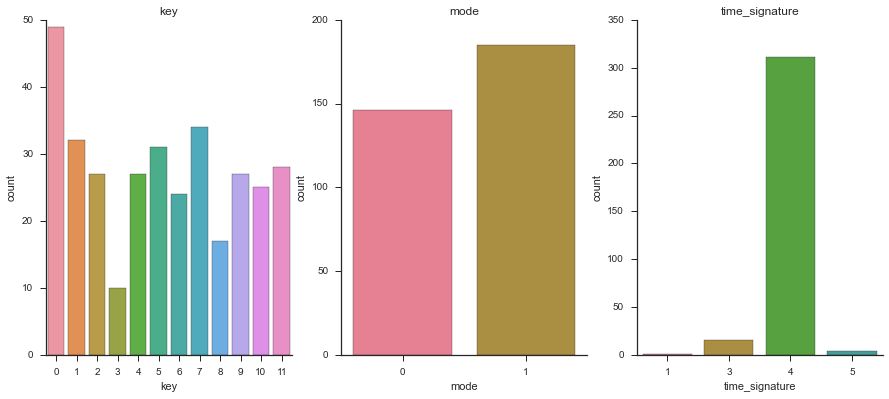

In [41]:
# create 3 subplots
fig4, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3,
                                      sharey=False,
                                      figsize=(15,6))

# remove the top and right spines from plots
sns.despine()

count_plot_attr(df=test_df, hue=None)

I visualize the data to see if there are any patterns. Again, I use pairplot to create a matrix of scatterplots to see the relationships in the dataset. 

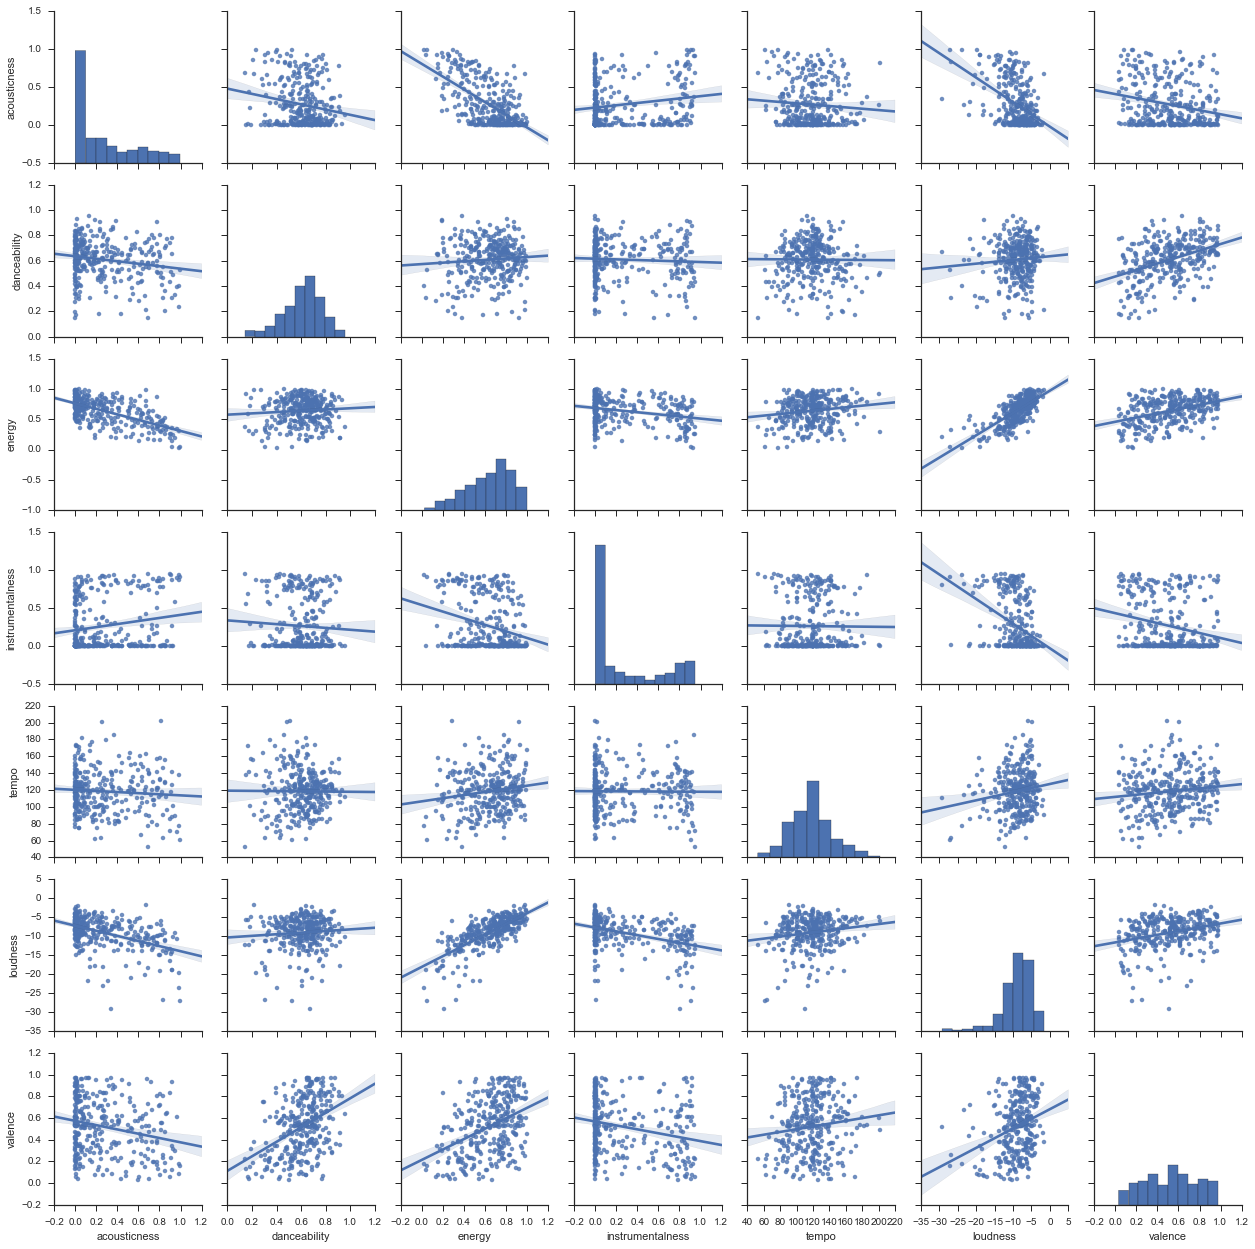

In [26]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(test_df, 
             vars=['acousticness', 'danceability', 
                   'energy', 'instrumentalness', 
                   'tempo', 'loudness','valence'],
            kind="reg")

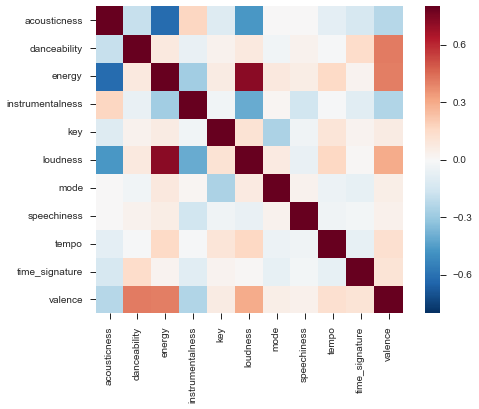

In [37]:
# compute a correlation matrix
corrmat = test_df.corr()

# set up the matplotlib figure
fig3, ax = plt.subplots(figsize=(12, 9))

# draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=.8, square=True)

In [28]:
print "Correlation matrix, values"
corrmat

Correlation matrix, values


,acousticness,danceability,energy,instrumentalness,key,loudness,mode,speechiness,tempo,time_signature,valence
acousticness,1.00,-0.18,-0.62,0.17,-0.10,-0.47,0.00,0.00,-0.08,-0.13,-0.23
danceability,-0.18,1.00,0.08,-0.06,0.04,0.08,-0.03,0.04,-0.01,0.15,0.42
energy,-0.62,0.08,1.00,-0.28,0.06,0.72,0.08,0.06,0.16,0.03,0.41
instrumentalness,0.17,-0.06,-0.28,1.00,-0.03,-0.40,0.02,-0.15,-0.01,-0.09,-0.24
key,-0.10,0.04,0.06,-0.03,1.00,0.11,-0.25,-0.04,0.10,0.03,0.06
loudness,-0.47,0.08,0.72,-0.40,0.11,1.00,0.07,-0.06,0.16,0.01,0.30
mode,0.00,-0.03,0.08,0.02,-0.25,0.07,1.00,0.04,-0.05,-0.07,0.05
speechiness,0.00,0.04,0.06,-0.15,-0.04,-0.06,0.04,1.00,-0.03,-0.02,0.04
tempo,-0.08,-0.01,0.16,-0.01,0.10,0.16,-0.05,-0.03,1.00,-0.07,0.13
time_signature,-0.13,0.15,0.03,-0.09,0.03,0.01,-0.07,-0.02,-0.07,1.00,0.11
